In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os


In [5]:
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip


--2024-06-06 17:16:11--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia601606.us.archive.org/13/items/food-5-k/Food-5K.zip [following]
--2024-06-06 17:16:12--  https://ia601606.us.archive.org/13/items/food-5-k/Food-5K.zip
Resolving ia601606.us.archive.org (ia601606.us.archive.org)... 207.241.227.86
Connecting to ia601606.us.archive.org (ia601606.us.archive.org)|207.241.227.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  7.00MB/s    in 77s     

2024-06-06 17:17:30 (5.54 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [6]:
!unzip -qq -o Food-5K.zip
!ls


 Food-5K      'TF Transfer Learning with Data Augmentation.ipynb'
 Food-5K.zip   __MACOSX


In [7]:
!ls training

ls: cannot access 'training': No such file or directory


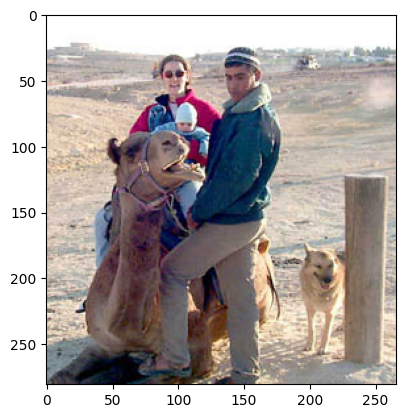

In [9]:
plt.imshow(image.load_img('Food-5K/training/0_208.jpg'))

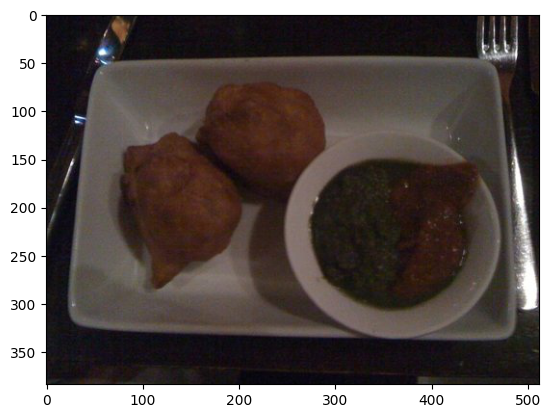

In [10]:
plt.imshow(image.load_img('Food-5K/training/1_208.jpg')) # We can see that img __ 1 are foods

In [11]:
!mkdir data

In [12]:
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [13]:
# Move the images
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food

In [33]:
os.remove("Food-5K.zip")


In [14]:
train_path = 'data/train'
valid_path = 'data/test'

In [15]:
IMAGE_SIZE = [200,200]

In [16]:
# Used to get the number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [17]:
# Used to get the number of classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

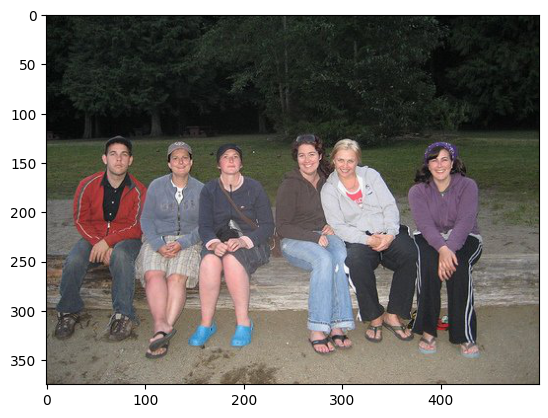

In [18]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [19]:
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
    include_top = False
)

2024-06-06 17:19:06.617034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 17:19:06.827278: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 17:19:06.827335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 17:19:06.829904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 17:19:06.829968: I external/local_xla/xla/stream_executor

In [20]:
# Freeze pretrained model weights
ptm.trainable = False

In [21]:
# map the data into feuture vectors
K = len(folders) # number of classes
x = Flatten()(ptm.output)
x = Dense(K,activation = 'softmax')(x)

In [22]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)


In [23]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [24]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [25]:
batch_size = 64

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [27]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

/tmp/ipykernel_31442/2348501944.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10


2024-06-06 17:19:16.905759: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-06 17:19:17.232238: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-06 17:19:17.761466: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-06 17:19:17.761628: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-06 17:19:17.951523: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran o

 1/47 [..............................] - ETA: 11:50 - loss: 4.8472 - accuracy: 0.6094

2024-06-06 17:19:30.895432: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1717683570.963078   47613 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 68s 1s/step - loss: 1.2929 - accuracy: 0.9357 - val_loss: 0.5010 - val_accuracy: 0.9770
Epoch 2/10
47/47 [==============================] - 36s 757ms/step - loss: 0.5516 - accuracy: 0.9753 - val_loss: 0.7036 - val_accuracy: 0.9770
Epoch 3/10
47/47 [==============================] - 35s 734ms/step - loss: 0.1995 - accuracy: 0.9860 - val_loss: 0.7320 - val_accuracy: 0.9720
Epoch 4/10
47/47 [==============================] - 35s 733ms/step - loss: 0.2479 - accuracy: 0.9880 - val_loss: 1.0445 - val_accuracy: 0.9720
Epoch 5/10
47/47 [==============================] - 35s 736ms/step - loss: 0.2073 - accuracy: 0.9880 - val_loss: 1.1084 - val_accuracy: 0.9670
Epoch 6/10
47/47 [==============================] - 35s 736ms/step - loss: 0.1617 - accuracy: 0.9893 - val_loss: 1.1741 - val_accuracy: 0.9730
Epoch 7/10
47/47 [==============================] - 35s 739ms/step - loss: 0.2607 - accuracy: 0.9880 - val_loss: 1.1930 - val_accuracy: 0.9690
Epoch 8/10
47

In [28]:
# create a 2nd train generator which does not use data augmentation
# to get the true train accuracy
train_generator2 = gen_test.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
model.evaluate_generator(
    train_generator2,
    steps=int(np.ceil(len(image_files) / batch_size)))

Found 3000 images belonging to 2 classes.


/tmp/ipykernel_31442/2190599009.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(


[0.05901471525430679, 0.9980000257492065]

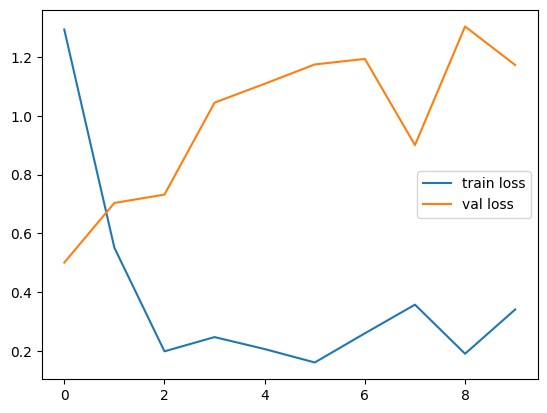

In [29]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

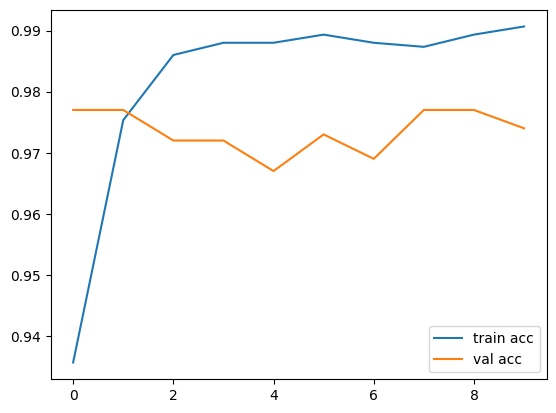

In [30]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

16/16 [==============================] - 6s 353ms/step


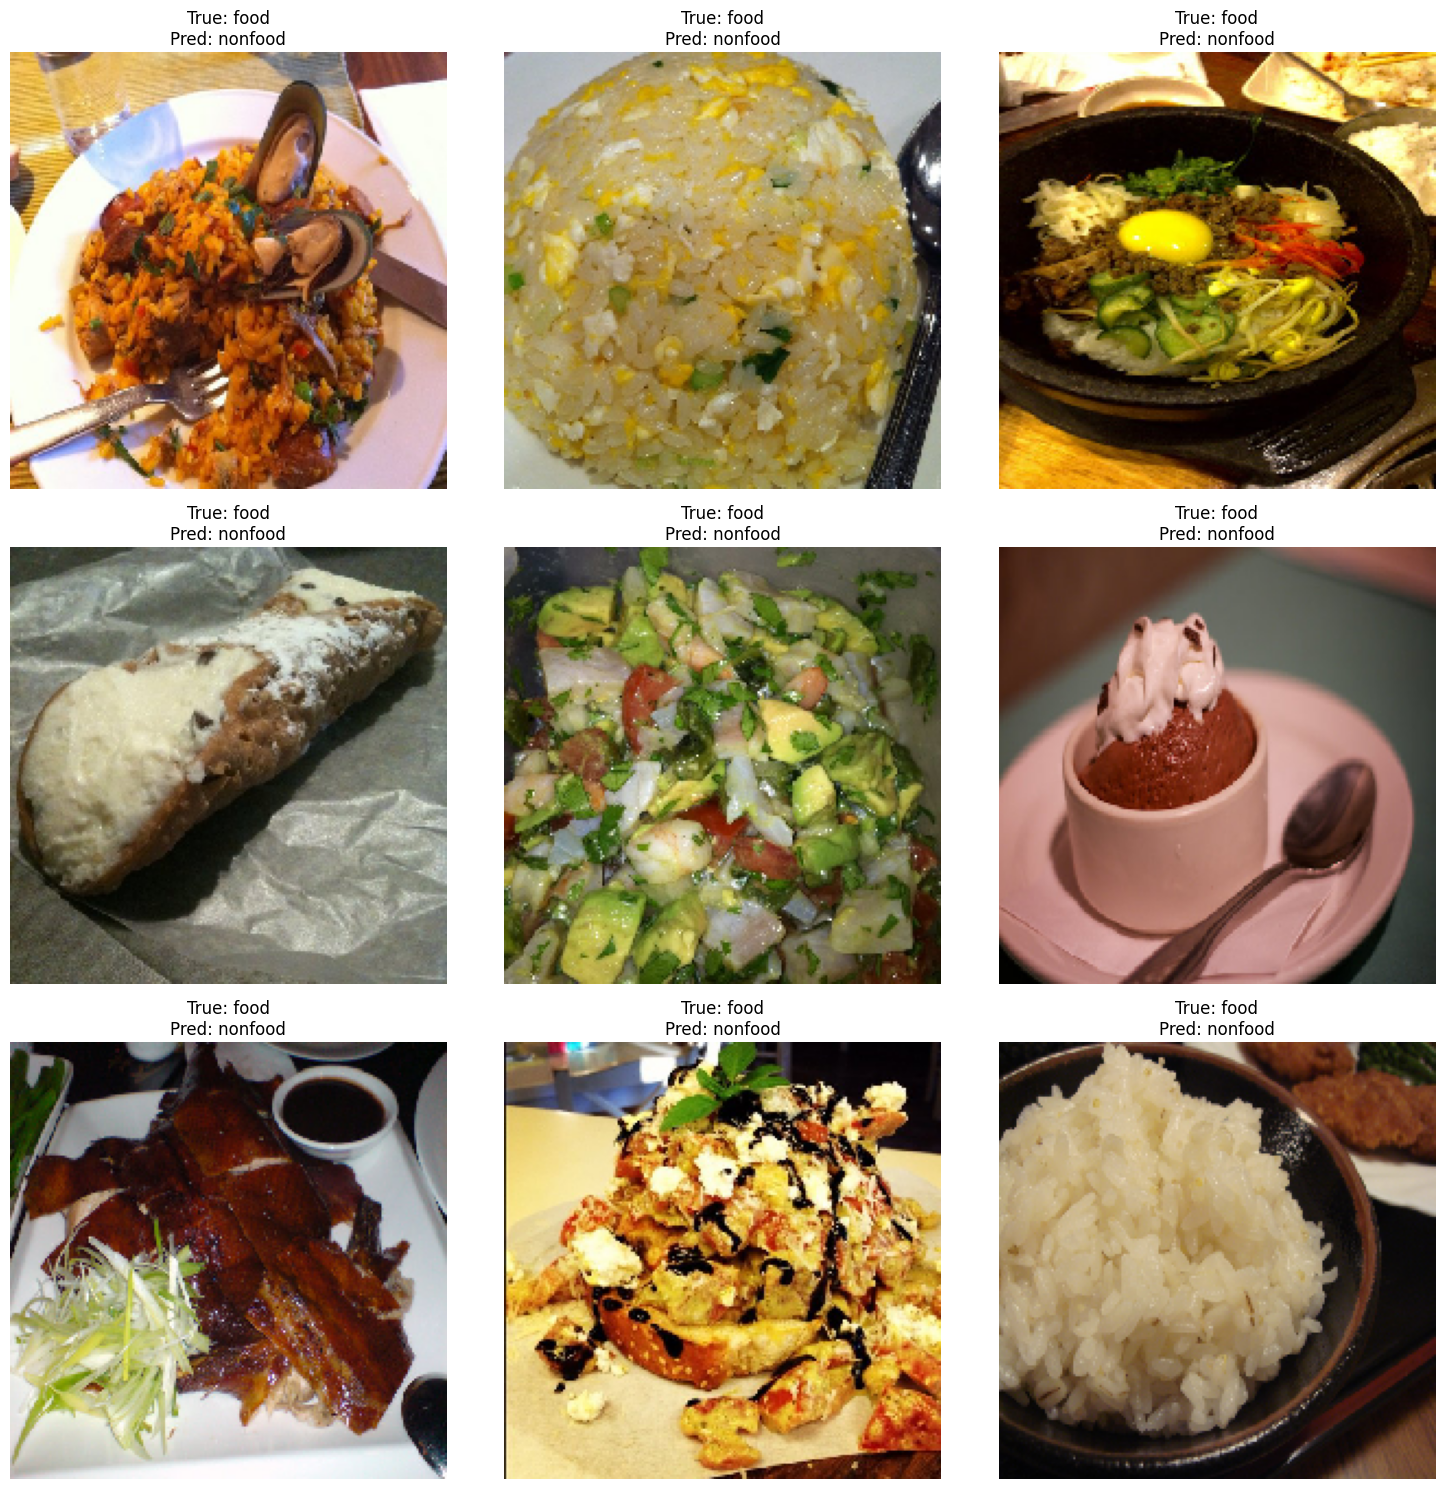

In [31]:
# Get the filenames and true labels from the validation generator
filenames = valid_generator.filenames
nb_samples = len(filenames)

# Predict the probabilities for the validation set
predictions = model.predict(valid_generator, steps=np.ceil(nb_samples / batch_size))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())

# Get the indices of misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]

import matplotlib.pyplot as plt

# Plot misclassified images
def plot_misclassified_images(misclassified_indices, filenames, true_classes, predicted_classes, class_labels):
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(misclassified_indices[:9]):  # Displaying first 9 misclassified images
        plt.subplot(3, 3, i + 1)
        img_path = os.path.join(valid_path, filenames[idx])
        img = image.load_img(img_path, target_size=IMAGE_SIZE)
        plt.imshow(img)
        plt.title(f"True: {class_labels[true_classes[idx]]}\nPred: {class_labels[predicted_classes[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_misclassified_images(misclassified_indices, filenames, true_classes, predicted_classes, class_labels)
